# OpenStreetMap Data Case Study

## Map selection

In this project, I choose the map of Amsterdam on Open Street Map website.
- Amsterdam, The Netherlands: http://www.openstreetmap.org/export#map=13/52.3577/4.9054

This city is one of famous city on the world. I would like to know the best tips for travelling around this city through database queries. How can I contribute to improve this map for traveller ?

Because the size of full Amsterdam map is large (~3GB), I only selected the center of amsterdam. Later, I reduced the size of sample by using the script mentioned on the project description in order to test my code. I chose k = 5 as my starting point because its size is smaller than 50mb so it will make my code running faster.

## Map problem
After initially downloading a small sample size of the Amsterdam area and running it against a provisional procdure in "XMLtoCSVver1.py" file, I noticed 5 common problems with the data, which I will discuss in the following order:
- Inconsistent postal codes ("1234","1234AB","1234 AB").
- Inconsistent city name ("Amsteram", "Amsterdam ").
- Inconsistent telephone number ("'+31 12 345 6789','+31123456789','012 34 56 789','012-345 67 89','31-12-3456789').
- Second level of "k" tag with the value "gate_type" has different format:
```SQL
<tag k="gate_type" v="turning" />
<tag k="gate:type" v="turning" />
```
- The street names with spcecial character
~~~
Jozef Isra\xeblslaan = Jozef Israëlslaan
~~~

I have created a "main_audit.py" file to clean those data if possible.

For the audition of data, I have followed the instruction of project guidline and provide three python code:
```python
import main_audit #contains code for cleaning code.
%run downsamplingmap.py #create smaller osm file for code testing.
%run XMLtoCSVver1.py # the main file for running audition, cleaning file, export to csv files.
%run import_csv_2_sql.py #create database for SQL queries from csv files.
```

### Inconsistent postal codes
In Netherlands, all of postal code is started with 4 digits followed by 2 letters (example: 1234AB). After auditing, most of postal codes have same struture. So, the only job is to update those postal codes in same format by removing " " between digits and letters. In my opinion, this problem is caused by typing. For the case of postal code that has only 4 digits, I leave it.
```python
def update_postalcode(name):
    if " " in name:
        name = name.replace(" ","")
    return name
```

### Inconsistent city name
Because this map focuses on Amsterdam, there is a lot of address which has city name "Amsterdam". It increases chance to get wrong city name typing. Through auditing city name, I found 2 specific errors. First is extra space after the name (example: "Amsterdam "). Second is missing letter "d" in the string (example: "Amsteram"). The correction of these errors is in below function:
```python
def update_city(name):
    if name.endswith(" "):
        name = name[0:(len(name)-1)]
    if name == "Amsteram":
        name = "Amsterdam"
    return name
```

### Inconsistent telephone number
This is the most popular problem when we observe the database. There are several different ways to input phone number. NOrmally, we can easily recognize those number but it is not nice to display a series of different format on screen. The below code is formatting all phone number into one struture: "012 3456 789" without country code (+31).
```python
def update_telephone(num):
    num = num.replace('+','').replace('-',"").replace(" ","")
    new_num = '0' + num[(len(num)-9):]
    new_num = new_num[:3] + '-' + new_num[3:7] + '-' + new_num[7:]
    return new_num
```

### Tag name
When auditing the relation tag, I found inconsistent name of "gate:type" so it needs to be corrected.
```python
def update_gatetype(name):
    if name == "gate_type":
        return "gate:type"
    return name
```

### Street name
According to Dutch dictionary, there are special characters in dutch words. This feature makes the display of those words incorrect but the system will works easily. Therefore I keep no change at all for street name. This problem is due to language.

## Map overview

This section contains basic statistics about the dataset, the SQL queries used to gather them, and some additional ideas about the data in context.

### File sizes:
>- center_amsterdam.osm ........... 126.8 mb
>- mydb.db ........................ 82.2 mb
>- nodes.csv ...................... 35.1 mb
>- nodes_tags.csv ................. 28 mb
>- ways.csv ....................... 2.9 mb
>- ways_tags.csv .................. 7.3 mb
>- ways_nodes.csv ................. 9.7 mb
>- relations.csv .................. 43 kb
>- relations_tags.csv ............. 175 kb
>- relations_members.csv .......... 2 mb

### Number of nodes
```SQL
sqlite> SELECT COUNT(*) FROM nodes;
```
411450

### Number of ways
```SQL
sqlite> SELECT COUNT(*) FROM ways;
```
45046

### Number of relations
```SQL
sqlite> SELECT COUNT(*) FROM relations;
```
717

### Number of unique users
```SQL
sqlite> SELECT COUNT(DISTINCT(e.uid))          
FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways UNION ALL SELECT uid FROM relations) e;
```
714

In [1]:
import sqlite3
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Top 5 contributing users

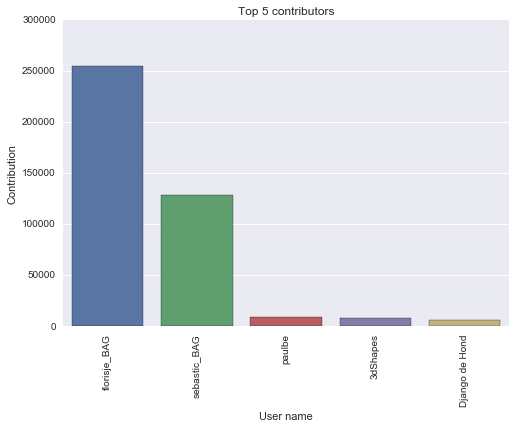

In [2]:
sqlite_file = 'mydb.db'    # name of the sqlite database file
conn = sqlite3.connect(sqlite_file)
cur = conn.cursor()
QUERY = ('''SELECT e.user, COUNT(*) as num
FROM (SELECT user FROM nodes UNION ALL SELECT user 
FROM ways UNION ALL SELECT user FROM relations) e
GROUP BY e.user
ORDER BY num DESC
LIMIT 5''')
cur.execute(QUERY)
all_rows = cur.fetchall()
data = pd.DataFrame(all_rows)
sns.barplot(data[0],data[1])
plt.title('Top 5 contributors')
plt.ylabel('Contribution')
plt.xlabel('User name')
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

### Contributor statistics
The contributions of users is not evenly distributed. In total 3 database of nodes, ways and relations, we have some user percentage statistics:
- Top user contribution is 55.72%.
- Top 2 users contribution is 83.70%.
- Top 5 users contribution is 88.83%.

In this statistics, we can see that the top users are working very actively in editing map. It raises severy question for me: are they map editor professional ? what are their motivation for contribution than the rest ?

## Additional Idea: Tips for travelling

### Restaurants
```SQL
sqlite> SELECT count(*) FROM nodes_tags WHERE value = 'restaurant';
```
603

#### Most popular cuisines

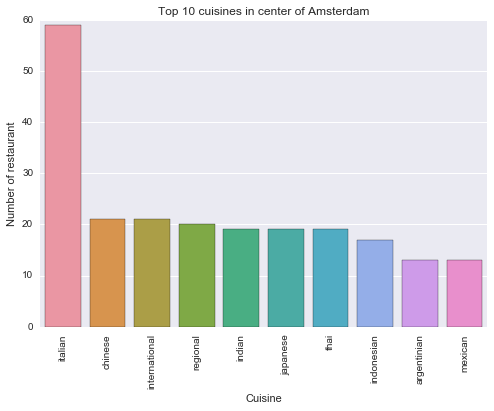

In [3]:
QUERY = ('''SELECT nodes_tags.value, COUNT(*) as num
FROM nodes_tags 
JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='restaurant') i
ON nodes_tags.id=i.id
WHERE nodes_tags.key='cuisine'
GROUP BY nodes_tags.value
ORDER BY num DESC
LIMIT 10
''')
cur.execute(QUERY)
all_rows = cur.fetchall()
data = pd.DataFrame(all_rows)
sns.barplot(data[0],data[1])
plt.title('Top 10 cuisines in center of Amsterdam')
plt.xlabel('Cuisine')
plt.ylabel('Number of restaurant')
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

It is not suprise when there are a lot of restaurant in a tourist attraction like Amsterdam, 603 restaurant. The most popular cuisine is italian which means that pizza is the top choice of tourists during travelling.

**Travel tip 1**: If you are looking for eating, there are a lot of restaurants which serve Italian food in Amsterdam.

### Transportation

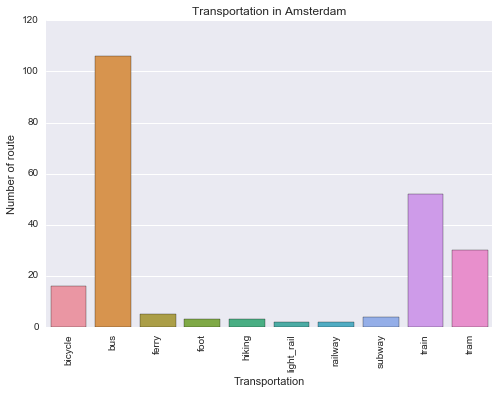

In [4]:
QUERY = ('''SELECT relations_tags.value, COUNT(*) as num
FROM relations_tags
WHERE key = 'route'
GROUP BY value
''')
cur.execute(QUERY)
all_rows = cur.fetchall()
data = pd.DataFrame(all_rows)
sns.barplot(data[0],data[1])
plt.title('Transportation in Amsterdam')
plt.ylabel('Number of route')
plt.xlabel('Transportation')
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

The center of Amsterdam is small so it is illogical if train is used for travelling around center. The explaination of this matter is that the train central station is located in this area and the number of route counts all train lines from Amsterdam to other cities.

**Travel tip 2**: You can easily go around center of Amsterdam by bus, tram, bicyle or subway.

### Attractions
```SQL
SELECT relations_tags.value
FROM relations_tags 
JOIN (SELECT DISTINCT(id) FROM relations_tags WHERE key='tourism') i
ON relations_tags.id=i.id
WHERE relations_tags.key='name'
```
|Place|
|---|
|West Indisch Huis
|Koninklijk Paleis op de Dam
|Hotel 83
|Hermitage
|Het Scheepvaartmuseum
|Koninklijk Instituut voor de Tropen
|NH Tropen Hotel
|Van Gogh Museum

**Travel tip 3**: The above list is the top tourist attractions in the center of Amsterdam.

### Rating implementation
My final purpose for this project is to provide a good tips for travellers. Therefore, I would recommend to implement a "rating" with "review" function into OSM. Naturally, there would be pros and cons for this implementation:
- Benefits:
    1. OSM users will have a grading system to evaluate interesting points (nodes, ways or relations) on map.
    2. By reading those rating and review, travellers can easily choose their activities for this area.
- Challenges:
    1. The database of OSM file will be larger and it will make longer time to do audition and queries with the addtion of "rating" and "review".
    2. The schema of database would be more complexity. I have to create another 'rating' and 'review' child tag inside the dictionary of nodes, ways and relations. For each those child tag, it would contain score, review, user, user_id, datetime.
    3. The duplication of reviews of a unique OSM user is potentially occurred and I need to build a function to keep only the lastest review.
    4. An implementation of score averaging for each points is needed.

## Conclusion
- The review of this database provides me a lot of information about center of Amsterdam. There are several errors in database but I believe it has been well cleaned for the requirements of this exercise. There is one limitaion in my cleaning that I don't clean the name of street because of language problem.
- By doing queries, it interests me to notice about the contributor's efforts. Top 2 users contributed more than 80% of map. It would like great to contact all contributors and get their feedback about map edition on OSM.
- Through those information, my idea is to create a tourist guideline in Amsterdam. It would be great to have another tags called "rating" and "review" to evaluate the interesting rate of one specific location. 
- Because of the limit of data submission, I only used a part of Amsterdam city so it is not completely describe the full picture of that city. I would prefer to obtain larger Amsterdam map (up to 3GB) and do those queries again.  